In [1]:
pathToluene = "20210511/092 2021 Toluol"
pathBuffer = "20210511/093 2021 Wasser"
pathSample = "20210511/094 2021 PS-Standard 1zu1000"
refracParticle = 1.492

### Helpers

In [2]:
# from NB 'Monitor Diode Analysis over Time'
import os
def findASC(inPath, pattern):
    for (dirpath, dirnames, filenames) in os.walk(inPath):
        if pattern not in os.path.basename(dirpath).lower():
            continue # skip dir if pattern not in its name
        #print(dirpath)
        ascfiles = [fn for fn in filenames if fn.endswith('.ASC') and '_averaged.' not in fn]
        #print(ascfiles)
        for fn in ascfiles:
            yield os.path.join(dirpath, fn)

from dateutil.parser import parse
def getMonitorDiode(filename):
    print('.', end="") # some progress output
    #print("getMonitorDiode", filename)
    try:
        with open(filename, encoding='cp1250') as fd:
            lines = fd.readlines()
            value = [line for line in lines if line.startswith('Monitor Diode')]
            value = float(value[0].split()[-1])
            datestr = [line for line in lines if line.startswith('Date')]
            datestr = datestr[0].split()[-1].strip('"')
            timestr = [line for line in lines if line.startswith('Time')]
            timestr = timestr[0].split()[-1].strip('"')
            ts = parse(datestr+' '+timestr)
            #print(datestr, timestr, ts)
            return value, ts
    except Exception as e:
        #print(e) # for debugging
        pass
    return -1., None

In [3]:
# from 'Analyse DLS with CONTIN'
import matplotlib.pyplot as plt
def initFigure(fig, width = 80, aspectRatio = 4./3., quiet=False):
    mmInch = 25.4
    fig.set_size_inches(width/mmInch, width/aspectRatio/mmInch)
    w, h = fig.get_size_inches()
    if not quiet:
        print("initFigure() with ({w:.1f}x{h:.1f}) mm"
              .format(w = w*mmInch, h = h*mmInch))
    return fig
    
def createFigure(width = 80, aspectRatio = 4./3., quiet=False, **kwargs):
    """output figure width in mm"""
    fig = plt.figure(
        #tight_layout = dict(pad = 0.05),
        **kwargs
    )
    initFigure(fig, width, aspectRatio, quiet)
    return fig

In [4]:
# from '2020-07-31 DLS concentration vs. count rate'
from dateutil.parser import parse
import pandas as pd

def parseValue(val):
        val = val.strip('" ')
        try:
            val = float(val)
        except ValueError:
            pass
        return val
def getDLSFileMeta(filenameOrBuffer):
        # read the measurement settings (temperature, viscosity, refractive index and wavelength)
        # only for 'ALV-7004 CGS-8F Data' data files
        meta = pd.read_csv(filenameOrBuffer, r'\s*:\s+', skiprows=1, nrows=36, encoding='cp1250',
                           names=['name', 'value'], index_col='name', engine='python')
        meta = {key: parseValue(value)
                for (key, value) in meta.to_dict()['value'].items()}
        return meta

def getDLSFileData(filename, showProgress=False):
    if showProgress:
        print('.', end="") # some progress output
    data = dict(filename=os.path.basename(filename))
    header = getDLSFileMeta(filename)
    data.update(timestamp=parse(header['Date']+' '+header['Time']))
    #print(header)
    memostr = "".join([value for key,value in header.items() if key.startswith("SampMemo")])
    # try to get the concentration from the memo field
    #print("memostr", memostr)
    memofields = [field.strip(' ,;') for field in memostr.split()]
    #print("memofields", memofields)
    try:
        concentration = [float(field.split(':')[1]) for field in memofields if ':' in field][0]
        concentration = 1/float(concentration)
    except (IndexError, ValueError):
        concentration = 1
    data.update(concentration=concentration)
    angles = [value for key,value in header.items() if key.startswith("Angle")]
    data.update(angles=angles)
    for name in "Temperature", "Viscosity", "Refractive Index", "Wavelength":
        for key,value in header.items():
            if key.startswith(name):
                data[key] = value
    with open(filename, encoding='cp1250') as fd:
        lines = fd.readlines()
        #[print(ln.strip()) for ln in lines[17:25]]
        value = [line for line in lines if line.startswith('Monitor Diode')]
        value = float(value[0].split()[-1])
        data.update(monitorDiode=value)
        #print("data", data)
        crstart = int([idx for idx, ln in enumerate(lines) if 'Count Rate' in ln][0])+1
        crend   = int([idx for idx, ln in enumerate(lines) if 'Monitor Diode' in ln][0])-1
    # read tabular data after file was closed by leaving scope of 'with'
    cr = pd.read_csv(filename, skiprows=crstart, nrows=crend-crstart, sep=r'\s+', names=angles)
    data.update(countrate=cr)
    return data

def dfSortByColumn(df, colname):
    # sort the DataFrame by the given column via index
    df.set_index(colname, inplace=True)
    df.sort_index(inplace=True)
    # resetting the index to the default one (just numbered)
    df.reset_index(inplace=True)
    
def processDLSMeasurements(files, monitorDiodeRef=0):
    """Treat a set of files as measurement of the same sample,
       at different scattering angles and with repetitions, possibly.
       Returns count rate averages and std. deviations for each angle."""
    if isinstance(files, str):
        files = (files,)
    # gather all relevant data from files in a directory
    dirData = [getDLSFileData(fn) for fn in files]
    if not len(dirData):
        return
    #print(dirData)
    # create a DataFrame from that
    df = pd.DataFrame({key: [fileData[key] for fileData in dirData]
                       for key in dirData[0].keys() if key not in ("countrate", "angles")})
    monitorDiodeScale = monitorDiodeRef / df.monitorDiode.mean() if monitorDiodeRef != 0 else 1
    name = '+'.join(list(set([Path(fn).parent.name for fn in files])))
    summary = dict(name=name, timestamp=df.timestamp[0],
                   monitorDiode=df.monitorDiode.mean(),
                   monitorDiodeScale=monitorDiodeScale,
                   concentration=df.concentration[0])
    for name in ("Temperature", "Viscosity", "Refractive Index", "Wavelength"):
        for colname in df.columns:
           if colname.startswith(name):
               summary[colname] = df[colname].mean()
    print("Monitor diode reference: {:.0f}, this mon. diode: {:7.0f}, scale: {:.6f} ({})"
          .format(monitorDiodeRef, summary['monitorDiode'], monitorDiodeScale, summary['name']))
    # all sets of angles found in files in this directory, a set can have unique entries only
    dirAngles = set([tuple(fileData['angles']) for fileData in dirData])
    countRates = []
    for angles in dirAngles:
        # concatenate countrates (time series) of the same angles only (for averaging over time later)
        countRates.append(pd.concat([fileData['countrate']
                                     for fileData in dirData
                                     if tuple(fileData['angles']) == angles]))
    # count rate mean over all measurements (must be at same angles!)
    countrate = pd.concat(countRates, axis=1)*monitorDiodeScale
    print("Measurement angles:", sorted(countrate.columns.astype(int)))
    countrate.sort_index(axis=1, inplace=True)
    def seriesToDict(series, lbl):
        return {"{}{:.0f}".format(lbl, key): value for key, value in zip(series.index, series.values)}
    summary.update(seriesToDict(countrate.mean(), 'crmean'))
    summary.update(seriesToDict(countrate.std(), 'crstd'))
    return summary

def crAtAngle(summaryDict, degrees):
    return (summaryDict.get(f'crmean{degrees:.0f}', -1.),
            summaryDict.get(f'crstd{degrees:.0f}', -1.))

def crMean(summaryDict):
     return np.array([crAtAngle(summaryDict, theta)[0] for theta in getAngles(summaryDict)])

def getAngles(summaryDict):
    prefix = 'crmean'
    return sorted([int(key[len(prefix):]) for key in summaryDict.keys() if key.startswith(prefix)])

In [5]:
import numpy as np
from pathlib import Path
files = list(findASC(Path(pathToluene), ''))
[print(fn) for fn in files]
tolueneData = processDLSMeasurements(files)
crTol_mean = crMean(tolueneData)
tolueneData, crTol_mean

20210511/092 2021 Toluol/092 2021 Toluol0000_0001.ASC
20210511/092 2021 Toluol/092 2021 Toluol0001_0001.ASC
20210511/092 2021 Toluol/092 2021 Toluol0000_0003.ASC
20210511/092 2021 Toluol/092 2021 Toluol0001_0003.ASC
20210511/092 2021 Toluol/092 2021 Toluol0001_0002.ASC
20210511/092 2021 Toluol/092 2021 Toluol0000_0002.ASC
Monitor diode reference: 0, this mon. diode: 1567735, scale: 1.000000 (092 2021 Toluol)
Measurement angles: [26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 106, 114, 122, 130, 138, 146]


({'name': '092 2021 Toluol',
  'timestamp': Timestamp('2021-11-05 09:21:57'),
  'monitorDiode': 1567735.241666667,
  'monitorDiodeScale': 1,
  'concentration': 1,
  'Temperature [K]': 292.9479483333334,
  'Viscosity [cp]': 1.0067233333333334,
  'Refractive Index': 1.332,
  'Wavelength [nm]': 632.8000000000001,
  'crmean26': 43.76568994750656,
  'crmean34': 35.300256509186354,
  'crmean42': 29.42009682414698,
  'crmean50': 25.725738097112863,
  'crmean58': 24.02480984251968,
  'crmean66': 22.379991102362208,
  'crmean74': 18.575696404199476,
  'crmean82': 18.047641417322836,
  'crmean90': 18.456571299212598,
  'crmean98': 18.74653250656168,
  'crmean106': 22.270167165354326,
  'crmean114': 23.55174526246719,
  'crmean122': 24.25662440944882,
  'crmean130': 27.075581076115483,
  'crmean138': 32.21495543307087,
  'crmean146': 38.579473792650916,
  'crstd26': 0.6281944349500644,
  'crstd34': 0.5600758180648094,
  'crstd42': 0.4971762560560979,
  'crstd50': 0.4729210986748227,
  'crstd58': 

In [6]:
files = list(findASC(Path(pathBuffer), ''))
[print(fn) for fn in files]
bufferData = processDLSMeasurements(files, monitorDiodeRef=tolueneData['monitorDiode'])
crBuf_mean = crMean(bufferData)
bufferData, crBuf_mean

20210511/093 2021 Wasser/093 2021 Wasser0001_0001.ASC
20210511/093 2021 Wasser/093 2021 Wasser0000_0001.ASC
20210511/093 2021 Wasser/093 2021 Wasser0001_0003.ASC
20210511/093 2021 Wasser/093 2021 Wasser0000_0003.ASC
20210511/093 2021 Wasser/093 2021 Wasser0000_0002.ASC
20210511/093 2021 Wasser/093 2021 Wasser0001_0002.ASC
Monitor diode reference: 1567735, this mon. diode: 1563499, scale: 1.002709 (093 2021 Wasser)
Measurement angles: [26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 106, 114, 122, 130, 138, 146]


({'name': '093 2021 Wasser',
  'timestamp': Timestamp('2021-11-05 09:37:16'),
  'monitorDiode': 1563499.4000000001,
  'monitorDiodeScale': 1.00270920581528,
  'concentration': 1,
  'Temperature [K]': 292.958765,
  'Viscosity [cp]': 1.0066016666666668,
  'Refractive Index': 1.332,
  'Wavelength [nm]': 632.8000000000001,
  'crmean26': 1.137993350177964,
  'crmean34': 1.4736662712223125,
  'crmean42': 2.1126336461367243,
  'crmean50': 1.8571613418886073,
  'crmean58': 2.1322631000032124,
  'crmean66': 2.059952265063872,
  'crmean74': 1.557851012247477,
  'crmean82': 4.540278442690203,
  'crmean90': 1.7510574302599746,
  'crmean98': 2.230746092694812,
  'crmean106': 2.4274767177518273,
  'crmean114': 2.3922360421514783,
  'crmean122': 2.406635235843082,
  'crmean130': 2.7153727558365395,
  'crmean138': 3.3789636028189376,
  'crmean146': 4.065864820212763,
  'crstd26': 0.10690094354946669,
  'crstd34': 0.11420645165819406,
  'crstd42': 0.8200136192754032,
  'crstd50': 0.1463872760327078,
  

In [7]:
files = list(findASC(Path(pathSample), ''))
[print(fn) for fn in files]
particleData = processDLSMeasurements(files, monitorDiodeRef=tolueneData['monitorDiode'])
crTot_mean = crMean(particleData)
particleData, crTot_mean

20210511/094 2021 PS-Standard 1zu1000/094 2021 PS-Standard 1zu10000000_0001.ASC
20210511/094 2021 PS-Standard 1zu1000/094 2021 PS-Standard 1zu10000001_0001.ASC
20210511/094 2021 PS-Standard 1zu1000/094 2021 PS-Standard 1zu10000001_0002.ASC
20210511/094 2021 PS-Standard 1zu1000/094 2021 PS-Standard 1zu10000000_0002.ASC
20210511/094 2021 PS-Standard 1zu1000/094 2021 PS-Standard 1zu10000000_0003.ASC
20210511/094 2021 PS-Standard 1zu1000/094 2021 PS-Standard 1zu10000001_0003.ASC
Monitor diode reference: 1567735, this mon. diode:   21146, scale: 74.138438 (094 2021 PS-Standard 1zu1000)
Measurement angles: [26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 106, 114, 122, 130, 138, 146]


({'name': '094 2021 PS-Standard 1zu1000',
  'timestamp': Timestamp('2021-11-05 09:53:49'),
  'monitorDiode': 21146.051666666666,
  'monitorDiodeScale': 74.13843805829474,
  'concentration': 0.001,
  'Temperature [K]': 292.94768,
  'Viscosity [cp]': 1.0067166666666667,
  'Refractive Index': 1.332,
  'Wavelength [nm]': 632.8000000000001,
  'crmean26': 15133.777544051438,
  'crmean34': 12006.84455038834,
  'crmean42': 10042.491970070512,
  'crmean50': 8786.208455768925,
  'crmean58': 8036.366376766467,
  'crmean66': 7169.260172431157,
  'crmean74': 5850.116246833783,
  'crmean82': 5536.634960267955,
  'crmean90': 5627.621207568462,
  'crmean98': 5521.3148377563275,
  'crmean106': 6339.459283024175,
  'crmean114': 6486.356220004008,
  'crmean122': 6513.708692859357,
  'crmean130': 7091.0207316456335,
  'crmean138': 8427.009168200375,
  'crmean146': 9810.531228863412,
  'crstd26': 3563.6179464460265,
  'crstd34': 2244.0671289783772,
  'crstd42': 1470.6357780684464,
  'crstd50': 1133.3337193

### Rayleigh ratio
*"The Rayleigh ratio of toluene is known from the literature and is equal to 1.35·10e−5·cm−1 at 632.8 nm and 25 °C (Brar and Verma 2011)"*

In [8]:
rayleighRatio = 1.35e-5 # in 1/cm at wavelength of 632.8 nm and 25 °C
(crTot_mean - crBuf_mean) * rayleighRatio

array([0.20429063, 0.16207251, 0.13554512, 0.11858874, 0.10846216,
       0.0967572 , 0.07895554, 0.07468328, 0.07594925, 0.07450764,
       0.08554993, 0.08753351, 0.08790258, 0.09569212, 0.11371901,
       0.13238728])

## The differential scattering cross section using Mie theory

See https://pymiescatt.readthedocs.io/en/latest/forward.html#functions-for-single-particles

Refractive Index of
- Polypropylene, PP: 1.492 (https://www.osapublishing.org/ao/abstract.cfm?uri=ao-42-3-592)
- Polystyrene, PS: 1.593

### Using [miepython](https://miepython.readthedocs.io/en/latest/index.html)

See also https://miepython.readthedocs.io/en/latest/03_angular_scattering.html#Differential-Scattering-Cross-Section  
cites [Wiscombe, W. J. (1979). Mie Scattering Calculations. doi:10.5065/D6ZP4414](https://opensky.ucar.edu/islandora/object/technotes:232)

In [9]:
import collections.abc
import miepython
def diffScatteringCrossSection(radius, angles, wavelen, nMedium, verbose=False):
    geometric_cross_section = np.pi * radius**2 * 1e-14 # cm**2
    if not isinstance(angles, (collections.Sequence, np.ndarray)):
        angles = np.array([angles])
    mu = np.cos(np.radians(angles))
    m, x = refracParticle/nMedium, np.pi*2*radius/(wavelen/nMedium)
    if verbose:
        print(wavelen, 2*radius, nMedium, refracParticle/nMedium, x, geometric_cross_section)
    qext, qsca, qback, g = miepython.mie(m,x)
    return geometric_cross_section * qext * miepython.i_unpolarized(m,x,mu)

In [10]:
import numpy as np
radius = 850.
wavelen = bufferData["Wavelength [nm]"]
nMedium = bufferData["Refractive Index"]
angles = getAngles(tolueneData)
# angles = np.linspace(0,180,1000)
sigma_sca = diffScatteringCrossSection(radius, angles, wavelen, nMedium, verbose=True)

632.8000000000001 1700.0 1.332 1.12012012012012 11.241817959527065 2.2698006922186254e-08


<ipython-input-9-1c22239a3ff2>:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  if not isinstance(angles, (collections.Sequence, np.ndarray)):


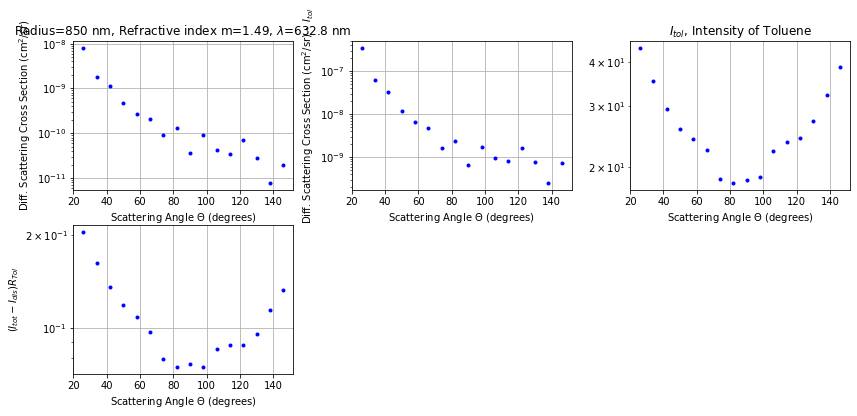

In [11]:
import matplotlib.pyplot as plt
createFigure(300, 2.2, quiet=True, tight_layout = {'pad': 0.05});
plt.subplot(2,3,1)
plt.plot(angles, sigma_sca, '.', color='blue')
plt.yscale('log'); plt.grid(True)
plt.title(f"Radius={radius:.0f} nm, Refractive index m={refracParticle:.2f}, $\lambda$={wavelen:.1f} nm")
plt.xlabel(r"Scattering Angle $\Theta$ (degrees)");
plt.ylabel("Diff. Scattering Cross Section (cm$^2$/sr)");

plt.subplot(2,3,2)
plt.plot(angles, sigma_sca*crTol_mean, '.', color='blue')
plt.yscale('log'); plt.grid(True)
plt.xlabel(r"Scattering Angle $\Theta$ (degrees)");
plt.ylabel("Diff. Scattering Cross Section (cm$^2$/sr)$\;\cdot\; I_{tol}$");

plt.subplot(2,3,3)
plt.plot(angles, crTol_mean, '.', color='blue')
plt.yscale('log'); plt.grid(True)
plt.title("$I_{tol}$, Intensity of Toluene")
plt.xlabel(r"Scattering Angle $\Theta$ (degrees)");

plt.subplot(2,3,4)
plt.plot(angles, (crTot_mean - crBuf_mean) * rayleighRatio, '.', color='blue')
plt.yscale('log'); plt.grid(True)
plt.ylabel(r"$(I_{tot}-I_{dis}) R_{Tol}$")
plt.xlabel(r"Scattering Angle $\Theta$ (degrees)");

## Get the intensity distribution

**According to Malvern:**  
*"The first order result from a DLS experiment is an intensity distribution of particle sizes. The intensity distribution is naturally weighted according to the scattering intensity of each particle fraction or family. For biological materials or polymers the particle scattering intensity is proportional to the square of the molecular weight."*  
( https://www.chem.uci.edu/~dmitryf/manuals/Fundamentals/DLS%20terminology.pdf )

**Check:**  
[The CONTIN algorithm and its application to determine the size distribution of microgel suspensions ](https://doi.org/10.1063/1.4921686)

## Run CONTIN

In [12]:
continConfig = dict(
    angle=90,
    ptRangeSec=(3e-7, 1e0), fitRangeM=(1e-9, 500e-9), gridpts=500,
    transformData=True, freeBaseline=True, weighResiduals=False,
)

In [13]:
getAngles(particleData)

[26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 106, 114, 122, 130, 138, 146]

In [14]:
files

['20210511/094 2021 PS-Standard 1zu1000/094 2021 PS-Standard 1zu10000000_0001.ASC',
 '20210511/094 2021 PS-Standard 1zu1000/094 2021 PS-Standard 1zu10000001_0001.ASC',
 '20210511/094 2021 PS-Standard 1zu1000/094 2021 PS-Standard 1zu10000001_0002.ASC',
 '20210511/094 2021 PS-Standard 1zu1000/094 2021 PS-Standard 1zu10000000_0002.ASC',
 '20210511/094 2021 PS-Standard 1zu1000/094 2021 PS-Standard 1zu10000000_0003.ASC',
 '20210511/094 2021 PS-Standard 1zu1000/094 2021 PS-Standard 1zu10000001_0003.ASC']

In [15]:
import analyse_dls_with_contin.contin

In [16]:
from analyse_dls_with_contin.contin import processFiles, getContinResults
resultDirs = processFiles(files, continConfig, nthreads=None)
resultDirs


CONTIN analysis with 12 threads took 11.8s.


[PosixPath('20210511/094 2021 PS-Standard 1zu1000/contin_090 094 2021 PS-Standard 1zu10000000_0001'),
 PosixPath('20210511/094 2021 PS-Standard 1zu1000/contin_090 094 2021 PS-Standard 1zu10000000_0002'),
 PosixPath('20210511/094 2021 PS-Standard 1zu1000/contin_090 094 2021 PS-Standard 1zu10000000_0003')]

{'temp': 292.95,
 'angle': 90.0,
 'visc': 0.0010065999999999999,
 'refrac': 1.332,
 'wavelen': 6.328e-07}

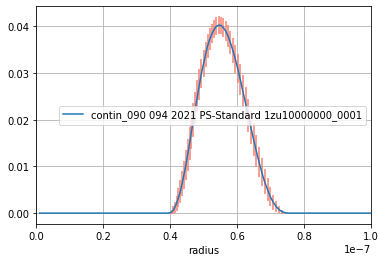

In [17]:
# show first result for testing
dn = resultDirs[0]
dfDistrib, dfFit, varmap = getContinResults(dn)
dfDistrib.plot('radius', 'distrib', yerr='err', ecolor='salmon', grid=True, label=dn.name);
plt.xlim(0,1e-7);
varmap

In [19]:
theta = 90.
I_tot = crAtAngle(particleData, theta)[0]
I_dis = crAtAngle(bufferData, theta)[0]
I_tol = crAtAngle(tolueneData, theta)[0]

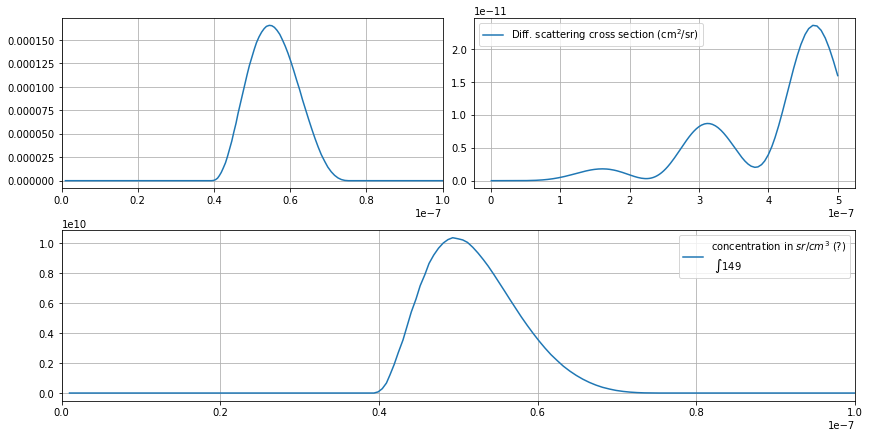

In [22]:
from analyse_dls_with_contin.jupyter_analysis_tools.distrib import area

createFigure(300, 2, quiet=True, tight_layout = {'pad': 0.05});
plt.subplot(2,2,1); plt.grid()
plt.plot(dfDistrib.radius.values,
         dfDistrib.distrib.values * (I_tot - I_dis) * rayleighRatio / (I_tol))
plt.xlim(0,1e-7)
plt.subplot(2,2,2); plt.grid()
sigma_sca = np.array([diffScatteringCrossSection(radius, theta, wavelen, nMedium)
                      for radius in dfDistrib.radius.values*1e9]).flatten()
plt.plot(dfDistrib.radius.values, sigma_sca, label="Diff. scattering cross section (cm$^2$/sr)")
plt.legend()
plt.subplot(2,1,2); plt.grid()
concentration = dfDistrib.distrib.values * (I_tot - I_dis) * rayleighRatio / (I_tol*sigma_sca)
plt.plot(dfDistrib.radius.values, concentration,
         label="concentration in $sr/cm^3$ (?)\n"+area(dfDistrib.radius.values, concentration));
plt.legend(); plt.xlim(0,1e-7);